## Setting file paths

#### FT-RDM Model 

In [1]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

plots_folder_name = 'FT-RDM/'
dataset_name = 'fastText_subtlex_FT.csv'
stan_file_name = 'RDM_hier_2k_beta_f.stan'
saved_model_name = 'FT-RDM'

plots_path = plots_root + plots_folder_name
dataset_path = datasets_root + dataset_name
stan_file_path = stan_files_root + stan_file_name
saved_model_path = saved_models_root + saved_model_name  + '.pkl'

## Importing Packages

In [2]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from scipy.stats import gaussian_kde

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [4]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,cornbread,140,1,2.963932,LF,9.994057e-01,0.000594
1,pains,2259,1,3.723198,HF,9.999964e-01,0.000004
2,quivers,84,1,2.467925,LF,9.949029e-01,0.005097
3,cutback,67,1,2.547107,LF,9.994540e-01,0.000546
4,pourn,0,0,0.000000,NW,7.554672e-06,0.999992
...,...,...,...,...,...,...,...
74312,beacan,0,0,0.000000,NW,1.223383e-08,1.000000
74313,unsold,255,1,2.194924,LF,9.999645e-01,0.000035
74314,imitating,469,1,3.260317,HF,9.998357e-01,0.000164
74315,evidence,62334,1,4.928923,HF,9.994597e-01,0.000540


In [5]:
def remove_outliers(df, max_rt, min_rt, std_c=2.5):
    """
    Returns remove outliers from dataframes. Outlier RTs are bigger than
    max_rt and smaller than min_rt. Also RTsthat are out of -/+ (std_c * sd) 
    of mean RT interval are considered as outliers too.

    Parameters
    ----------
        df: pandas dataframe with rt column
        max_rt (float): maximum acceptable rt
        min_rt (float): minimum acceptable rt
        
    Optional Parameters
    ----------
        std_c (float) : Optional
            coefficient to define interval of non-outlier RTs
    
    Returns
    -------
        df: pandas dataframe without outliers  
    """
    mean = df['rt'].mean()
    sd = df['rt'].std()
    lower_thr = mean - std_c*sd
    upper_thr = mean + std_c*sd
    min_bound = max(min_rt, lower_thr)
    max_bound = min(max_rt, upper_thr)
    df = df[df['rt'] >= min_bound]
    df = df[df['rt'] <= max_bound]
    return df

Reading and modifing each behavioral data file and combining all of them into a single behavioral dataframe

In [6]:
Number_Of_Participants = 3
Number_Of_Trials = 400
dataframes = []

for i in range(Number_Of_Participants):
    # Loading each file
    df = pd.read_csv(behavioural_data_root + str(i+1) + "DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
    # Dropping non rows and first two rows that are demographic informations 
    df = df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials] 
    # Converting columns type to suitable data types
    convert_dict = {'string_type': 'int16',
                    'accuracy': 'int16',
                    'rt': float
                   }

    df = df.astype(convert_dict)
    # Convert RTs to seconds
    df['rt'] = df['rt'].apply(lambda x: x/1000) 
    # Removing Outliers
    df = remove_outliers(df, 3, .2, 2.5)
    # Extracting response of participant from his/her accuracy
    df['response'] = np.logical_not(np.logical_xor(df['string_type'], df['accuracy'])).astype('int')
    df = df.reset_index(drop=True)
    # Particpant number
    df['participant'] = i+1
    # Minimum RT of participant in all trials (is needed for stan code)
    df['minRT'] = df['rt'].min()
    dataframes.append(df)

In [7]:
# Combining dataframes
behavioural_df = pd.concat(dataframes)
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["trial", "string_type", "freq"], axis=1)

In [8]:
behavioural_df.head()

,accuracy,rt,string,response,participant,minRT,label,zipf,category,word_prob,non_word_prob
0,0,0.707,bookie,0,1,0.412,1.0,3.409105,HF,9.982517e-01,0.001748
1,1,0.769,gandbrake,0,1,0.412,0.0,0.000000,NW,3.736372e-08,1.000000
2,1,0.526,philosophical,1,1,0.412,1.0,3.205648,HF,9.968132e-01,0.003187
3,0,0.510,umbeaten,1,1,0.412,0.0,0.000000,NW,5.537812e-05,0.999945
4,1,0.512,belonging,1,1,0.412,1.0,3.317140,HF,9.985624e-01,0.001438


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [9]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                         non_word_prob  \
              mean       std count       max           min          mean   
category                                                                   
HF        0.992615  0.060056   224  1.000000  1.081290e-01      0.007385   
LF        0.982822  0.078786   301  1.000000  4.057633e-09      0.017178   
NW        0.005913  0.061245   558  0.946264  7.235630e-26      0.994087   

                                                  
               std count       max           min  
category                                          
HF        0.060056   224  0.891871  2.929536e-12  
LF        0.078786   301  1.000000  9.740403e-09  
NW        0.061245   558  1.000000  5.373600e-02

RT and response description of words and non-words in different conditions in all trials
across participants

In [10]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'], 'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.612295  0.217862  1.660  0.301  0.946429  0.225674   1   0
LF        0.692000  0.233223  1.707  0.271  0.843854  0.363598   1   0
NW        0.720186  0.245556  1.763  0.200  0.161290  0.368129   1   0

## Stan Model and Estimation

Compiling stan model

In [11]:
rdm_model = cmdstanpy.CmdStanModel(stan_file=stan_file_path)

13:39:04 - cmdstanpy - INFO - compiling stan file D:\Internship-2021\v2-cmd stan py\stan files\RDM_hier_2k_beta_f.stan to exe file D:\Internship-2021\v2-cmd stan py\stan files\RDM_hier_2k_beta_f.exe
13:39:41 - cmdstanpy - INFO - compiled model executable: D:\Internship-2021\v2-cmd stan py\stan files\RDM_hier_2k_beta_f.exe
13:39:41 - cmdstanpy - WARNING - Stan compiler has produced 24 warnings:
13:39:41 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/mahva/AppData/Local/Temp/tmp2zqvcwu0/tmpv3ap_3mg.hpp C:/Users/mahva/AppData/Local/Temp/tmp2zqvcwu0/tmpv3ap_3mg.stan
Warning in 'C:/Users/mahva/AppData/Local/Temp/tmp2zqvcwu0/tmpv3ap_3mg.stan', line 51, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/mahva/AppData/Loca

behavioural_df['zipf'].to_numpy().astype(int)Preparing model's inputs

In [15]:
N = len(behavioural_df) # number of all trials
participant = behavioural_df['participant'].to_numpy() # participants number
x = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy() # predicted probabilites of words and non-words
frequency = behavioural_df['zipf'].to_numpy().astype(int) # zipf values
response = behavioural_df['response'].to_numpy().astype(int) # participants responses
rt = behavioural_df['rt'].to_numpy() # participants RTs 
minRT = behavioural_df['minRT'].to_numpy() # participants min RT                     
RTbound = 0

threshold_priors = [4, 2, 1, 2] 
g_priors = [-2, 1, 0, 1] 
m_priors = [0, 0.5, 0, 1] 
alpha_priors = [0, 1, 1, 1]
b_priors = [0, 1, 1, 1];
k_priors = [2, 1, 1, 1]

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'x' : x,
             'frequency': frequency,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'threshold_priors': threshold_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
            }

# set sampling parameters
n_iter = 1000
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [16]:
fit = rdm_model.sample(data=data_dict,
                             iter_sampling=n_sample, 
                             iter_warmup=n_warmup,
                             chains=n_chains, 
                             show_console=True)

13:49:18 - cmdstanpy - INFO - Chain [1] start processing
13:49:18 - cmdstanpy - INFO - Chain [2] start processing


Chain [2] method = sample (Default)Chain [1] method = sample (Default)

Chain [2] sample
Chain [2] num_samples = 500
Chain [2] num_warmup = 500
Chain [2] save_warmup = 0 (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [2] engaged = 1 (Default)
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [2] delta = 0.80000000000000004 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [1] sample
Chain [1] num_samples = 500
Chain [1] num_warmup = 500
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [2] window = 25 (Default)
Chain [2] algorithm = hmc (Default)
Chain [2] hmc
Chain [2] engine = nuts (Default)
Chain [2] nuts
Chain [2] max_depth = 10 (Default)
Chain [2] metric = diag_e (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [2] metric_file =  (D

13:55:52 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 207.021 seconds (Warm-up)
Chain [1] 187.055 seconds (Sampling)
Chain [1] 394.076 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 


KeyboardInterrupt: 

In [ ]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

Chain [2] Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain [2] Iteration: 1000 / 1000 [100%]  (Sampling)


13:56:53 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 234.561 seconds (Warm-up)
Chain [2] 220.03 seconds (Sampling)
Chain [2] 454.591 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 


In [33]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,182.422000,0.378901,5.729920,171.933000,182.505000,191.451000,228.688,0.370934,1.004420
mu_g,-3.690750,0.024889,0.732916,-4.874610,-3.691350,-2.409800,867.128,1.406490,0.999190
mu_m,-0.206440,0.014952,0.357920,-0.768296,-0.204601,0.393081,573.012,0.929430,0.998806
mu_threshold_word,1.812220,0.041828,0.729920,0.824296,1.694500,3.248010,304.516,0.493927,1.007270
mu_threshold_nonword,2.487580,0.028572,0.669200,1.475900,2.443560,3.646980,548.585,0.889809,0.998106
...,...,...,...,...,...,...,...,...,...
log_lik[1079],-0.199351,0.003978,0.120092,-0.407706,-0.194992,-0.007684,911.544,1.478530,0.999021
log_lik[1080],1.051880,0.001754,0.055411,0.960215,1.053940,1.140870,997.698,1.618270,0.999196
log_lik[1081],-0.119353,0.003069,0.099107,-0.292725,-0.114220,0.032656,1042.960,1.691700,0.999509


In [35]:
counter = 0
print("***Rhat >= 1.01 or  <= 0.9")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat >= 1.01 or  <= 0.9
0


In [37]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


In [38]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saving Model

In [82]:
with open(saved_model_path, "wb") as f:
    pickle.dump({'model' : rdm_model, 'fit' : fit}, f, protocol=-1)

## Check parameters

Loading Model

In [83]:
with open(saved_model_path, "rb") as f:
    data_dict = pickle.load(f)

fit = data_dict['fit']

Parameters posterior plots

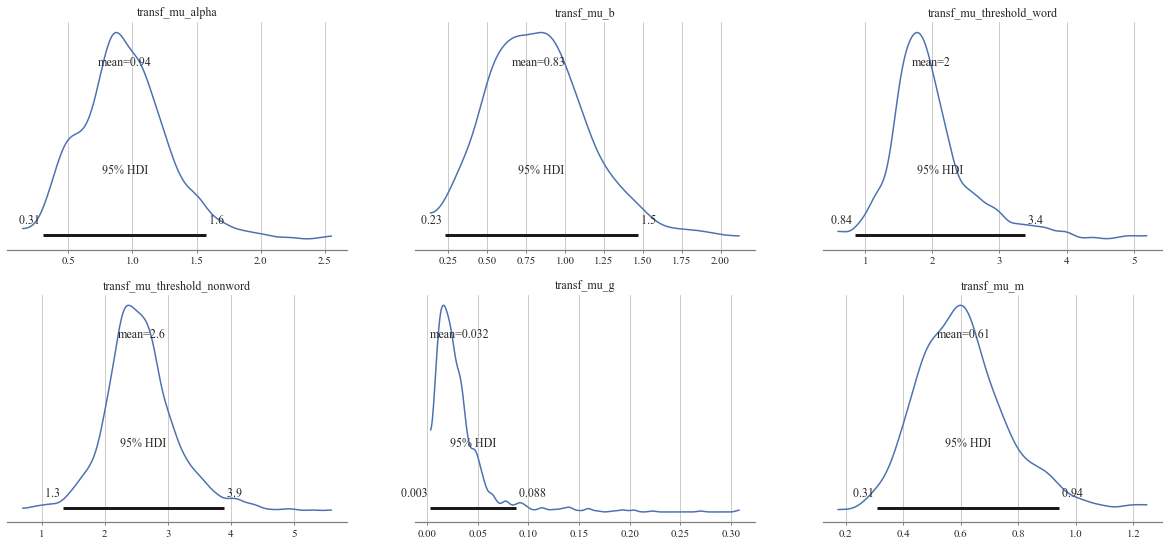

In [78]:
az.plot_posterior(fit, var_names=['transf_mu_alpha', 'transf_mu_b', 'transf_mu_threshold_word', 'transf_mu_threshold_nonword', 'transf_mu_g', 'transf_mu_m'], hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

#### Models mean parameters in different conditions

In [45]:
# Loading model parameters for each trial
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
threshold_t_word = fit.stan_variables()['threshold_t_word']
threshold_t_nonword = fit.stan_variables()['threshold_t_nonword']
ndt_t = fit.stan_variables()['ndt_t']

In [46]:
HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [47]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))

HF words, word drift mean and std:
4.372196965540178 0.1747443245682323
HF words, nonword drift mean and std:
2.9262572924151784 0.25280549346457426


In [48]:
print('LF words word drift mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))

LF words word drift mean and std:
3.564301029501661 0.1806912499669857
LF words nonword drift mean and std:
2.880615244720931 0.24953526508887652


In [49]:
print('NW words word drift mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

NW words word drift mean and std:
1.3920374285253063 0.197428681568239
NW words nonword drift mean and std:
4.666617004749104 0.20218026750871332


In [50]:
HF_condition_w = threshold_t_word[:, behavioural_df['category']=="HF"]
HF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="HF"]
LF_condition_w = threshold_t_word[:, behavioural_df['category']=="LF"]
LF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="LF"]
NW_condition_w = threshold_t_word[:, behavioural_df['category']=="NW"]
NW_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="NW"]

In [51]:
print('HF words, word threshold mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword threshold mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))

HF words, word threshold mean and std:
1.7218056331964282 0.1182285421428891
HF words, nonword threshold mean and std:
2.4207371629017853 0.15300076023226683


In [52]:
print('LF words word threshold mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword threshold mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))

LF words word threshold mean and std:
1.7123294202225912 0.11680646884283424
LF words nonword threshold mean and std:
2.410220740132891 0.15150558349093712


In [53]:
print('NW words word threshold mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword threshold mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

NW words word threshold mean and std:
1.726775934777777 0.11706216970959149
NW words nonword threshold mean and std:
2.4267503028136197 0.1516344532560488


In [54]:
HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [55]:
print('HF words ndt_t mean and std:')
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))

HF words ndt_t mean and std:
0.17902410525670984 0.01610753812778171


In [56]:
print('LF words ndt_t mean and std:')
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))

LF words ndt_t mean and std:
0.18560033246382063 0.016083990757904842


In [57]:
print('Non Words ndt_t mean and std:')
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

Non Words ndt_t mean and std:
0.18462151311098562 0.01646992386561663


## Calculating metrics

In [58]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [60]:
log_likelihood = fit.stan_variables()['log_lik']
calculate_waic(log_likelihood)

{'lppd': 216.13163672214895,
 'p_waic': 24.21046957334255,
 'waic': -383.8423342976128,
 'waic_se': 79.0247194665435}

## Simulating RDM with estimated parameters

In [61]:
def random_rdm_2A(cor_drift, inc_drift, threshold_word, threshold_nonword, ndt, noise_constant=1, dt=0.001, max_rt=10):
    """ 
    Simulates behavior (rt and accuracy) according to the Racing Diffusion Model.
     
    Parameters
    ----------
    cor_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - correct trials.
    inc_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - incorrect trials.
    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.
    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.
    
    Optional Parameters
    ----------------
    noise_constant : float, default 1
        Scaling factor of the Racing Diffusion Model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.
    dt : float, default 0.001
        Controls the time resolution of the Racing Diffusion Model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.
    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.
    
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = cor_drift.shape
    acc = np.empty(shape)
    rt = np.empty(shape)
    acc[:] = np.nan
    rt[:] = np.nan

    max_tsteps = max_rt/dt

    x_cor = np.zeros(shape)
    x_inc = np.zeros(shape)

    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    stop_race = False

    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x_cor[ongoing] += np.random.normal(cor_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        x_inc[ongoing] += np.random.normal(inc_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        tstep += 1
        ended_correct = (x_cor >= threshold_word)
        ended_incorrect = (x_inc >= threshold_nonword)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct, ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect, ongoing)]
            ongoing[ended_incorrect] = False
    return rt, acc

Simulating RDM with estimated parameters

In [62]:
pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [63]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [64]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [65]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF']
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF']
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF']
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF']
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW']
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW']

## Quantiles Posterior Predictions

In [66]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [67]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

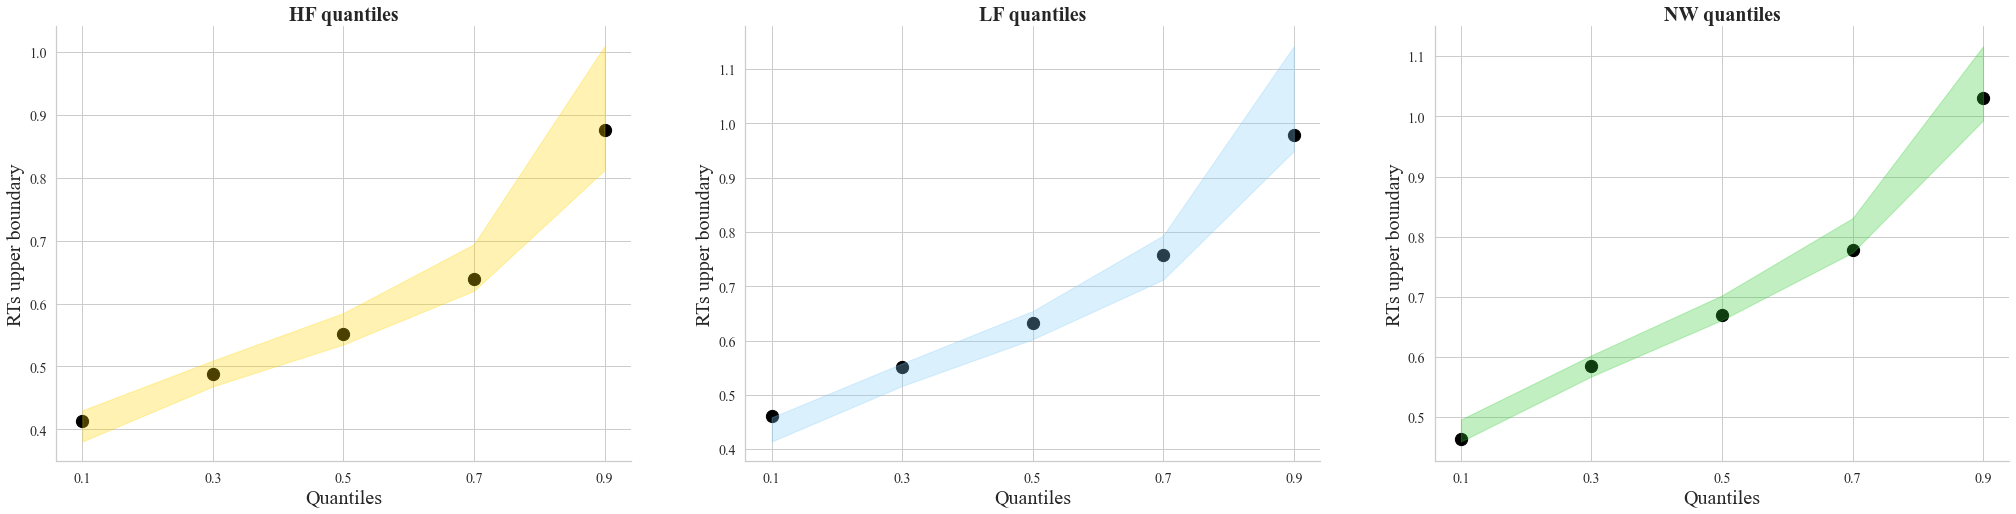

In [68]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=150)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=150)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=150)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=20)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14) 

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior.pdf')

## Mean Accuracy and RT Posterior Plots

In [69]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


C:\Users\mahva\AppData\Local\Temp\ipykernel_14356\447608752.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
C:\Users\mahva\AppData\Local\Temp\ipykernel_14356\447608752.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
C:\Users\mahva\AppData\Local\Temp\ipykernel_14356\447608752.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  NW_pred_rt_mean = NW_pred_rt.mean(axis=0)
C:\Users\mahva\AppData\Local

In [70]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color='lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

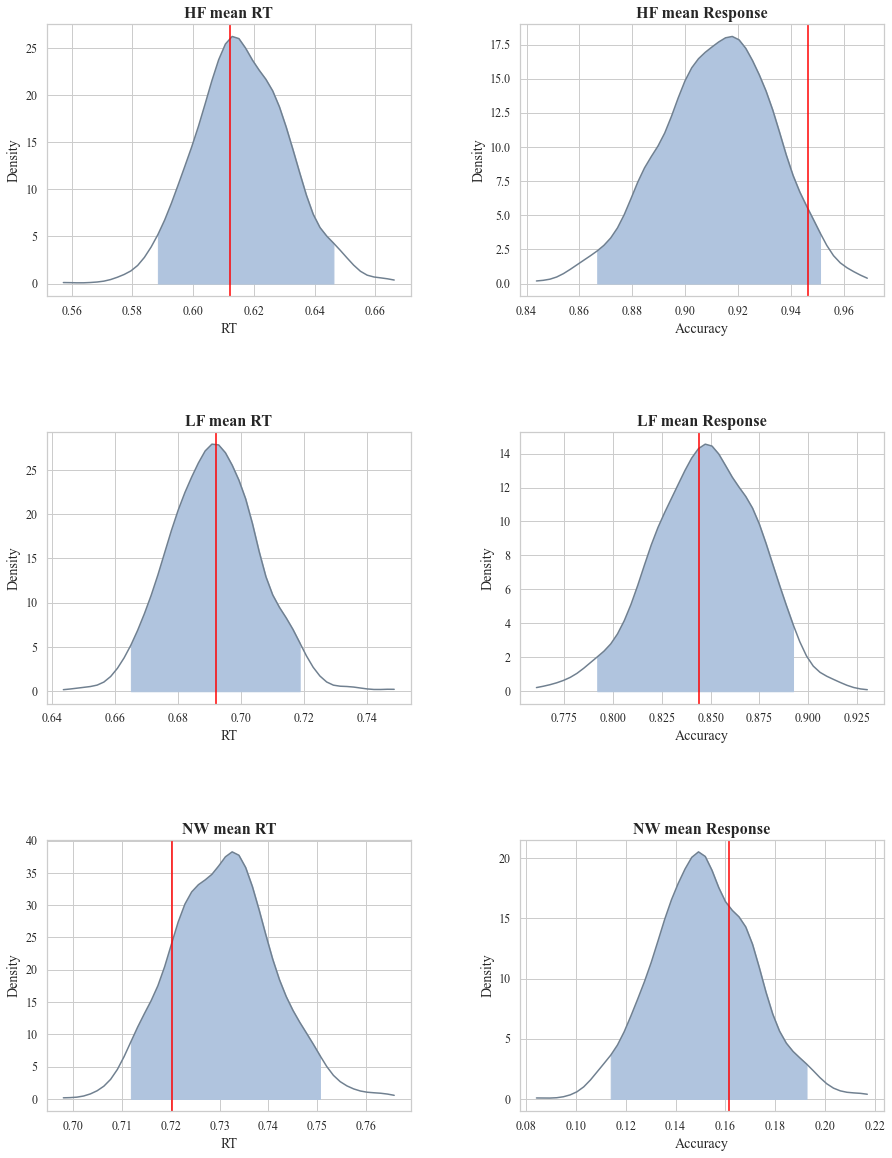

In [71]:
fig, axes = plt.subplots(3,2 , figsize=(15,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=14)
        ax[1].set_xlabel('Accuracy', fontsize=14)
        ax[0].set_ylabel('Density', fontsize=14)
        ax[1].set_ylabel('Density', fontsize=14)
        for tick in ax[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(12)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label.set_fontsize(12) 

plt.savefig(plots_path + 'Mean Accuracy and RT.pdf')